# Cell 1: Import Libraries and Setup Device
"""
This cell imports all the necessary libraries and sets up the device for GPU computation if available.
We are using PyTorch for deep learning, OpenCV for image processing, and Matplotlib/Seaborn for visualization.
"""

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import cv2
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from tqdm import tqdm
import os
import numpy as np
import time
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from torchvision.models import resnet50, ResNet50_Weights

# Cek apakah kode dijalankan di Google Colab
IN_COLAB = 'google.colab' in str(get_ipython())

# Cek apakah GPU tersedia, jika tidak gunakan CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Mount Google Drive jika menggunakan Google Colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')


Using device: cuda
Mounted at /content/drive


# Cell 2: Define Data Loading and Preprocessing Functions
"""
This cell contains functions to load and preprocess images from the dataset.
The `load_data` function loads images from the specified directory and assigns labels based on the folder structure.
The `preprocess_image` function applies CLAHE and unsharp masking to enhance image quality.
The `CustomDataset` class integrates these functions and prepares the dataset for use in PyTorch.
"""

In [ ]:
def load_data(dataset_path, subset):
    images = []
    labels = []

    # Tentukan label sesuai dengan subset

    label_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']



    # Pemetaan nama label ke indeks
    label_map = {name: idx for idx, name in enumerate(label_names)}

    subset_path = os.path.join(dataset_path, subset)
    for label_name in label_names:
        image_dir = os.path.join(subset_path, label_name)
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Directory not found: {image_dir}")
        for file_name in os.listdir(image_dir):
            if file_name.endswith('.png'):  # Cek jika file adalah gambar PNG
                image_path = os.path.join(image_dir, file_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Warning: Unable to load image {image_path}")
                    continue
                images.append(image)
                labels.append(label_map[label_name])
                print(f"Loaded image {image_path}")
    return images, labels
def preprocess_image(image):
    if image is None or image.size == 0:
        raise ValueError("Empty image provided for preprocessing")

    # Terapkan CLAHE untuk meningkatkan kontras
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(10, 10))

    clahe_image = clahe.apply(image)

    # Terapkan Gaussian Blur untuk menghaluskan gambar
    #gaussian = cv2.GaussianBlur(image, (9, 9), 10.0)
    # Terapkan Unsharp Masking untuk meningkatkan ketajaman gambar
    #unsharp_image = cv2.addWeighted(clahe_image, 1.5, gaussian, -0.5, 0, clahe_image)
    #unsharp_image = cv2.addWeighted(gaussian, 1.5, gaussian, -0.5, 0)

    return clahe_image

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Terapkan transformasi jika ada
        if self.transform:
            image = self.transform(image)
        if image.dim() == 2:  # Pastikan gambar memiliki 3 dimensi
            image = image.unsqueeze(0)
        return image, label


# Cell 3: Load and Transform Data
"""
This cell loads the data and applies the necessary transformations.
The dataset is divided into training, validation, and test sets.
Each image is transformed into a 224x224 size tensor suitable for input to the VGG-16 model.
"""

In [ ]:
# Mengatur path dataset, disesuaikan untuk Google Colab atau Jupyter Notebook
dataset_path = '/content/drive/MyDrive/Chest-CT-Data'

# Load data
train_images, train_labels = load_data(dataset_path, 'train')
valid_images, valid_labels = load_data(dataset_path, 'valid')
test_images, test_labels = load_data(dataset_path, 'test')

print(f"Loaded {len(train_images)} training images with {len(train_labels)} labels")
print(f"Loaded {len(valid_images)} validation images with {len(valid_labels)} labels")
print(f"Loaded {len(test_images)} test images with {len(test_labels)} labels")

# Transformasi data untuk persiapan training, validation, dan testing
transform = transforms.Compose([
    transforms.ToPILImage(),             # Ubah dari array NumPy ke gambar PIL
    transforms.Resize((224, 224)),       # Ubah ukuran gambar menjadi 224x224
    #v2.RandomHorizontalFlip(),           # Randomly flip the image horizontally
   # v2.RandomRotation(15),                # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),               # Ubah gambar menjadi Tensor and normalize to [0, 1]
])

# Membuat dataset dan data loader untuk training, validation, dan testing
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
valid_dataset = CustomDataset(valid_images, valid_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # DataLoader untuk training
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False) # DataLoader untuk validasi
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)   # DataLoader untuk testing


Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000041 (7).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000093 (4).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000090 (2).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000072 (10).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000093 (6).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000050 (5).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000022 (10).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000008 (10).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000066 (9).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000020 (5).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000050 (8).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/t

# Cell 4: Load Model and Pruning
"""
This cell loads the pre-trained VGG-16 model and applies pruning to its convolutional layers.
Pruning is used to reduce the size of the model by setting certain weights to zero, based on a threshold.
"""

In [ ]:
# Load ResNet pretrained tanpa classifier (hanya sebagai feature extractor)
resnet_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#Resnet_features = nn.Sequential(*list(resnet_model.children()))  # Ambil bagian feature extractor

# Ambil bagian feature extractor (semua layer kecuali fully connected)
Resnet_features = nn.Sequential(*list(resnet_model.children())[:-1])  # Keluarkan layer fully connected atau layer klasifikasi

#num_ftrs = resnet_model.fc.in_features   # No. of input features to fully connected layer

# Freeze semua parameter di feature extractor
#for param in Resnet_features.parameters():
#    param.requires_grad = False

# Custom Model dengan ResNet50 feature extractor + Fully Connected Layers untuk klasifikasi
class CustomResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet50Classifier, self).__init__()
        # Feature extractor dari ResNet50
        self.features = Resnet_features
        #self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling

        # Fully connected layers untuk klasifikasi
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),  # Sesuaikan input sesuai dengan output dari feature extractor ResNet50
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Ekstraksi fitur
        x = self.features(x)
        x = self.classifier(x)  # Klasifikasi
        return x

# Jumlah kelas untuk klasifikasi
num_classes = 4

# Inisialisasi model
model = CustomResNet50Classifier(num_classes)

# Pindahkan model ke GPU jika tersedia, jika tidak gunakan CPU
model = model.to(device)



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


Penjelasan Kode:
Penambahan Fully Connected Layer:

nn.Linear(512 * 7 * 7, 1024) → Menghubungkan output dari feature extractor (25088 neuron) ke layer fully connected pertama dengan 1024 neuron.
nn.Linear(1024, 512) → Layer fully connected tambahan yang mengambil input dari layer sebelumnya dan mengubahnya menjadi 512 neuron.
nn.Linear(512, num_classes) → Layer fully connected terakhir untuk output ke jumlah kelas sesuai tugas klasifikasi (misalnya 4 kelas).

# Mengetahui Ukuran Model

In [ ]:
print(Resnet_features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
# Cek model
print(model)

CustomResNet50Classifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model)

# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
CustomResNet50Classifier (CustomResNet50Classifier)     [16, 3, 224, 224]    [16, 4]              --                   True
├─Sequential (features)                                 [16, 3, 224, 224]    [16, 2048, 1, 1]     --                   True
│    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (1)                                  [16, 64, 112, 112]   [16, 64, 112, 112]   128                  True
│    └─ReLU (2)                                         [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
│    └─MaxPool2d (3)                                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
│    └─Sequential (4)                                   [16, 64, 56, 56]     [16, 256, 56, 56]    --                   True
│    │ 

# Cell 5: Training Loop with Checkpointing
"""
This cell implements the training loop with checkpointing.
Checkpointing allows you to save the model's state after each epoch, so you can resume training later if needed.
The best model (based on validation loss) is also saved separately.
"""

Epoch 1/70 - Training: 100%|██████████| 76/76 [00:10<00:00,  7.08it/s, Loss=1.21]


Epoch [1/70], Train Loss: 1.2238, Accuracy: 0.4592, Precision: 0.4353, Recall: 0.4592, F1-Score: 0.4151


Epoch 1/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 22.01it/s, Loss=1.07]


Validation Loss: 1.0529, Accuracy: 0.4444, Precision: 0.6810, Recall: 0.4444, F1-Score: 0.3567
Checkpoint saved at checkpoint.pth.tar
Epoch [1/70] completed in 12.56 seconds


Epoch 2/70 - Training: 100%|██████████| 76/76 [00:09<00:00,  8.12it/s, Loss=0.982]


Epoch [2/70], Train Loss: 0.7877, Accuracy: 0.6839, Precision: 0.6989, Recall: 0.6839, F1-Score: 0.6708


Epoch 2/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 13.95it/s, Loss=1.07]


Validation Loss: 0.7640, Accuracy: 0.7531, Precision: 0.7965, Recall: 0.7531, F1-Score: 0.7621
Checkpoint saved at checkpoint.pth.tar
Epoch [2/70] completed in 12.38 seconds


Epoch 3/70 - Training: 100%|██████████| 76/76 [00:08<00:00,  8.79it/s, Loss=0.478]


Epoch [3/70], Train Loss: 0.3898, Accuracy: 0.8835, Precision: 0.8868, Recall: 0.8835, F1-Score: 0.8836


Epoch 3/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 30.98it/s, Loss=0.135]


Validation Loss: 0.3570, Accuracy: 0.8642, Precision: 0.8883, Recall: 0.8642, F1-Score: 0.8662
Checkpoint saved at checkpoint.pth.tar
Epoch [3/70] completed in 10.02 seconds


Epoch 4/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.66it/s, Loss=1.13]


Epoch [4/70], Train Loss: 0.1775, Accuracy: 0.9567, Precision: 0.9572, Recall: 0.9567, F1-Score: 0.9566


Epoch 4/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.85it/s, Loss=0.448]


Validation Loss: 0.3467, Accuracy: 0.8765, Precision: 0.8935, Recall: 0.8765, F1-Score: 0.8788
Checkpoint saved at checkpoint.pth.tar
Epoch [4/70] completed in 8.43 seconds


Epoch 5/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.81it/s, Loss=1.89]


Epoch [5/70], Train Loss: 0.1532, Accuracy: 0.9584, Precision: 0.9590, Recall: 0.9584, F1-Score: 0.9585


Epoch 5/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 27.43it/s, Loss=0.0142]


Validation Loss: 0.3853, Accuracy: 0.8642, Precision: 0.9049, Recall: 0.8642, F1-Score: 0.8685
Checkpoint saved at checkpoint.pth.tar
Epoch [5/70] completed in 8.16 seconds


Epoch 6/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.74it/s, Loss=0.366]


Epoch [6/70], Train Loss: 0.1468, Accuracy: 0.9601, Precision: 0.9600, Recall: 0.9601, F1-Score: 0.9600


Epoch 6/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 30.59it/s, Loss=0.118]


Validation Loss: 0.3290, Accuracy: 0.8765, Precision: 0.8819, Recall: 0.8765, F1-Score: 0.8768
Checkpoint saved at checkpoint.pth.tar
Epoch [6/70] completed in 8.21 seconds


Epoch 7/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.43it/s, Loss=0.336]


Epoch [7/70], Train Loss: 0.1277, Accuracy: 0.9651, Precision: 0.9652, Recall: 0.9651, F1-Score: 0.9650


Epoch 7/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 30.06it/s, Loss=0.0606]


Validation Loss: 0.5880, Accuracy: 0.7654, Precision: 0.8319, Recall: 0.7654, F1-Score: 0.7468
Checkpoint saved at checkpoint.pth.tar
Epoch [7/70] completed in 8.12 seconds


Epoch 8/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.76it/s, Loss=2.64]


Epoch [8/70], Train Loss: 0.1528, Accuracy: 0.9617, Precision: 0.9619, Recall: 0.9617, F1-Score: 0.9618


Epoch 8/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.98it/s, Loss=0.0519]


Validation Loss: 0.2162, Accuracy: 0.8889, Precision: 0.8971, Recall: 0.8889, F1-Score: 0.8896
Checkpoint saved at checkpoint.pth.tar
Epoch [8/70] completed in 8.21 seconds


Epoch 9/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.30it/s, Loss=1.16]


Epoch [9/70], Train Loss: 0.1399, Accuracy: 0.9617, Precision: 0.9619, Recall: 0.9617, F1-Score: 0.9616


Epoch 9/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 30.13it/s, Loss=0.00192]


Validation Loss: 0.3418, Accuracy: 0.8395, Precision: 0.8902, Recall: 0.8395, F1-Score: 0.8430
Checkpoint saved at checkpoint.pth.tar
Epoch [9/70] completed in 8.28 seconds


Epoch 10/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.48it/s, Loss=1.67]


Epoch [10/70], Train Loss: 0.0982, Accuracy: 0.9684, Precision: 0.9685, Recall: 0.9684, F1-Score: 0.9684


Epoch 10/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 26.00it/s, Loss=0.00139]


Validation Loss: 0.2263, Accuracy: 0.9259, Precision: 0.9352, Recall: 0.9259, F1-Score: 0.9279
Checkpoint saved at checkpoint.pth.tar
Epoch [10/70] completed in 8.42 seconds


Epoch 11/70 - Training: 100%|██████████| 76/76 [00:08<00:00,  9.13it/s, Loss=1.81]


Epoch [11/70], Train Loss: 0.1061, Accuracy: 0.9684, Precision: 0.9685, Recall: 0.9684, F1-Score: 0.9684


Epoch 11/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.55it/s, Loss=0.0276]


Validation Loss: 0.2796, Accuracy: 0.8889, Precision: 0.9076, Recall: 0.8889, F1-Score: 0.8899
Checkpoint saved at checkpoint.pth.tar
Epoch [11/70] completed in 9.22 seconds


Epoch 12/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.12it/s, Loss=2.93]


Epoch [12/70], Train Loss: 0.0739, Accuracy: 0.9884, Precision: 0.9885, Recall: 0.9884, F1-Score: 0.9884


Epoch 12/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 30.23it/s, Loss=0.00672]


Validation Loss: 0.2144, Accuracy: 0.9136, Precision: 0.9275, Recall: 0.9136, F1-Score: 0.9158
Checkpoint saved at checkpoint.pth.tar
Epoch [12/70] completed in 8.70 seconds


Epoch 13/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.36it/s, Loss=2.2]


Epoch [13/70], Train Loss: 0.1213, Accuracy: 0.9684, Precision: 0.9690, Recall: 0.9684, F1-Score: 0.9684


Epoch 13/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.07it/s, Loss=0.0354]


Validation Loss: 0.2162, Accuracy: 0.9383, Precision: 0.9461, Recall: 0.9383, F1-Score: 0.9382
Checkpoint saved at checkpoint.pth.tar
Epoch [13/70] completed in 8.21 seconds


Epoch 14/70 - Training: 100%|██████████| 76/76 [00:07<00:00,  9.96it/s, Loss=0.489]


Epoch [14/70], Train Loss: 0.1235, Accuracy: 0.9534, Precision: 0.9535, Recall: 0.9534, F1-Score: 0.9533


Epoch 14/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.38it/s, Loss=0.000911]


Validation Loss: 0.1292, Accuracy: 0.9630, Precision: 0.9664, Recall: 0.9630, F1-Score: 0.9628
Checkpoint saved at checkpoint.pth.tar
Epoch [14/70] completed in 8.82 seconds


Epoch 15/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.07it/s, Loss=0.339]


Epoch [15/70], Train Loss: 0.0535, Accuracy: 0.9834, Precision: 0.9834, Recall: 0.9834, F1-Score: 0.9834


Epoch 15/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.92it/s, Loss=0.000347]


Validation Loss: 0.1580, Accuracy: 0.9136, Precision: 0.9235, Recall: 0.9136, F1-Score: 0.9141
Checkpoint saved at checkpoint.pth.tar
Epoch [15/70] completed in 8.69 seconds


Epoch 16/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.14it/s, Loss=0.0906]


Epoch [16/70], Train Loss: 0.0441, Accuracy: 0.9900, Precision: 0.9900, Recall: 0.9900, F1-Score: 0.9900


Epoch 16/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.02it/s, Loss=0.00467]


Validation Loss: 0.3972, Accuracy: 0.8642, Precision: 0.9217, Recall: 0.8642, F1-Score: 0.8740
Checkpoint saved at checkpoint.pth.tar
Epoch [16/70] completed in 8.38 seconds


Epoch 17/70 - Training: 100%|██████████| 76/76 [00:07<00:00,  9.99it/s, Loss=2.04]


Epoch [17/70], Train Loss: 0.0596, Accuracy: 0.9884, Precision: 0.9884, Recall: 0.9884, F1-Score: 0.9884


Epoch 17/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.64it/s, Loss=0.00943]


Validation Loss: 0.1991, Accuracy: 0.8889, Precision: 0.9138, Recall: 0.8889, F1-Score: 0.8929
Checkpoint saved at checkpoint.pth.tar
Epoch [17/70] completed in 8.44 seconds


Epoch 18/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.12it/s, Loss=2.3]


Epoch [18/70], Train Loss: 0.0744, Accuracy: 0.9850, Precision: 0.9852, Recall: 0.9850, F1-Score: 0.9850


Epoch 18/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.06it/s, Loss=0.00186]


Validation Loss: 0.2209, Accuracy: 0.9136, Precision: 0.9275, Recall: 0.9136, F1-Score: 0.9158
Checkpoint saved at checkpoint.pth.tar
Epoch [18/70] completed in 8.81 seconds


Epoch 19/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.09it/s, Loss=1.6]


Epoch [19/70], Train Loss: 0.0713, Accuracy: 0.9817, Precision: 0.9820, Recall: 0.9817, F1-Score: 0.9817


Epoch 19/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.38it/s, Loss=0.00011]


Validation Loss: 0.4427, Accuracy: 0.8642, Precision: 0.9217, Recall: 0.8642, F1-Score: 0.8762
Checkpoint saved at checkpoint.pth.tar
Epoch [19/70] completed in 8.38 seconds


Epoch 20/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.31it/s, Loss=2.09]


Epoch [20/70], Train Loss: 0.0646, Accuracy: 0.9850, Precision: 0.9853, Recall: 0.9850, F1-Score: 0.9850


Epoch 20/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.82it/s, Loss=0.00385]


Validation Loss: 0.2565, Accuracy: 0.9136, Precision: 0.9255, Recall: 0.9136, F1-Score: 0.9150
Checkpoint saved at checkpoint.pth.tar
Epoch [20/70] completed in 8.53 seconds


Epoch 21/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.28it/s, Loss=2.32]


Epoch [21/70], Train Loss: 0.0759, Accuracy: 0.9750, Precision: 0.9754, Recall: 0.9750, F1-Score: 0.9751


Epoch 21/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.91it/s, Loss=0.00336]


Validation Loss: 0.1423, Accuracy: 0.9383, Precision: 0.9437, Recall: 0.9383, F1-Score: 0.9395
Checkpoint saved at checkpoint.pth.tar
Epoch [21/70] completed in 8.21 seconds


Epoch 22/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.02it/s, Loss=0.648]


Epoch [22/70], Train Loss: 0.0411, Accuracy: 0.9900, Precision: 0.9901, Recall: 0.9900, F1-Score: 0.9900


Epoch 22/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 30.48it/s, Loss=0.000907]


Validation Loss: 0.2218, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9193
Checkpoint saved at checkpoint.pth.tar
Epoch [22/70] completed in 8.43 seconds


Epoch 23/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.35it/s, Loss=4.01]


Epoch [23/70], Train Loss: 0.0877, Accuracy: 0.9900, Precision: 0.9902, Recall: 0.9900, F1-Score: 0.9900


Epoch 23/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.72it/s, Loss=0.00684]


Validation Loss: 0.3096, Accuracy: 0.9012, Precision: 0.9224, Recall: 0.9012, F1-Score: 0.9043
Checkpoint saved at checkpoint.pth.tar
Epoch [23/70] completed in 8.18 seconds


Epoch 24/70 - Training: 100%|██████████| 76/76 [00:07<00:00,  9.96it/s, Loss=1.31]


Epoch [24/70], Train Loss: 0.0708, Accuracy: 0.9750, Precision: 0.9750, Recall: 0.9750, F1-Score: 0.9749


Epoch 24/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.68it/s, Loss=0.000305]


Validation Loss: 0.3364, Accuracy: 0.8765, Precision: 0.9020, Recall: 0.8765, F1-Score: 0.8798
Checkpoint saved at checkpoint.pth.tar
Epoch [24/70] completed in 8.47 seconds


Epoch 25/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.27it/s, Loss=0.883]


Epoch [25/70], Train Loss: 0.0713, Accuracy: 0.9850, Precision: 0.9851, Recall: 0.9850, F1-Score: 0.9850


Epoch 25/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.47it/s, Loss=0.0567]


Validation Loss: 0.1792, Accuracy: 0.9383, Precision: 0.9493, Recall: 0.9383, F1-Score: 0.9394
Checkpoint saved at checkpoint.pth.tar
Epoch [25/70] completed in 8.56 seconds


Epoch 26/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.06it/s, Loss=0.402]


Epoch [26/70], Train Loss: 0.0318, Accuracy: 0.9884, Precision: 0.9884, Recall: 0.9884, F1-Score: 0.9883


Epoch 26/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.97it/s, Loss=0.000766]


Validation Loss: 0.2108, Accuracy: 0.9012, Precision: 0.9278, Recall: 0.9012, F1-Score: 0.9063
Checkpoint saved at checkpoint.pth.tar
Epoch [26/70] completed in 8.41 seconds


Epoch 27/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.17it/s, Loss=2.19]


Epoch [27/70], Train Loss: 0.0495, Accuracy: 0.9933, Precision: 0.9935, Recall: 0.9933, F1-Score: 0.9934


Epoch 27/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.76it/s, Loss=0.00296]


Validation Loss: 0.1791, Accuracy: 0.9383, Precision: 0.9482, Recall: 0.9383, F1-Score: 0.9398
Checkpoint saved at checkpoint.pth.tar
Epoch [27/70] completed in 8.75 seconds


Epoch 28/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.31it/s, Loss=2.52]


Epoch [28/70], Train Loss: 0.0917, Accuracy: 0.9817, Precision: 0.9818, Recall: 0.9817, F1-Score: 0.9817


Epoch 28/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.24it/s, Loss=0.00714]


Validation Loss: 0.2023, Accuracy: 0.9383, Precision: 0.9464, Recall: 0.9383, F1-Score: 0.9385
Checkpoint saved at checkpoint.pth.tar
Epoch [28/70] completed in 8.21 seconds


Epoch 29/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.15it/s, Loss=3.32]


Epoch [29/70], Train Loss: 0.1118, Accuracy: 0.9717, Precision: 0.9717, Recall: 0.9717, F1-Score: 0.9717


Epoch 29/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.59it/s, Loss=0.00386]


Validation Loss: 0.4164, Accuracy: 0.8765, Precision: 0.9176, Recall: 0.8765, F1-Score: 0.8839
Checkpoint saved at checkpoint.pth.tar
Epoch [29/70] completed in 8.41 seconds


Epoch 30/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.35it/s, Loss=0.968]


Epoch [30/70], Train Loss: 0.0975, Accuracy: 0.9767, Precision: 0.9773, Recall: 0.9767, F1-Score: 0.9768


Epoch 30/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.98it/s, Loss=0.00742]


Validation Loss: 0.1470, Accuracy: 0.9630, Precision: 0.9642, Recall: 0.9630, F1-Score: 0.9624
Checkpoint saved at checkpoint.pth.tar
Epoch [30/70] completed in 8.26 seconds


Epoch 31/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.00it/s, Loss=1.58]


Epoch [31/70], Train Loss: 0.0340, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 31/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.63it/s, Loss=1.99e-5]


Validation Loss: 0.2554, Accuracy: 0.9136, Precision: 0.9342, Recall: 0.9136, F1-Score: 0.9174
Checkpoint saved at checkpoint.pth.tar
Epoch [31/70] completed in 8.56 seconds


Epoch 32/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.19it/s, Loss=1.3]


Epoch [32/70], Train Loss: 0.0281, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 32/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.44it/s, Loss=3.73e-5]


Validation Loss: 0.1965, Accuracy: 0.9136, Precision: 0.9336, Recall: 0.9136, F1-Score: 0.9173
Checkpoint saved at checkpoint.pth.tar
Epoch [32/70] completed in 8.63 seconds


Epoch 33/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.19it/s, Loss=4.68]


Epoch [33/70], Train Loss: 0.0768, Accuracy: 0.9917, Precision: 0.9917, Recall: 0.9917, F1-Score: 0.9917


Epoch 33/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.93it/s, Loss=2.49e-5]


Validation Loss: 0.2487, Accuracy: 0.9383, Precision: 0.9416, Recall: 0.9383, F1-Score: 0.9371
Checkpoint saved at checkpoint.pth.tar
Epoch [33/70] completed in 8.32 seconds


Epoch 34/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.01it/s, Loss=0.38]


Epoch [34/70], Train Loss: 0.0327, Accuracy: 0.9917, Precision: 0.9917, Recall: 0.9917, F1-Score: 0.9917


Epoch 34/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.66it/s, Loss=2.99e-5]


Validation Loss: 0.3326, Accuracy: 0.9136, Precision: 0.9230, Recall: 0.9136, F1-Score: 0.9125
Checkpoint saved at checkpoint.pth.tar
Epoch [34/70] completed in 8.49 seconds


Epoch 35/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.30it/s, Loss=2.66]


Epoch [35/70], Train Loss: 0.0962, Accuracy: 0.9750, Precision: 0.9752, Recall: 0.9750, F1-Score: 0.9751


Epoch 35/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.40it/s, Loss=0.0405]


Validation Loss: 0.1821, Accuracy: 0.9383, Precision: 0.9407, Recall: 0.9383, F1-Score: 0.9383
Checkpoint saved at checkpoint.pth.tar
Epoch [35/70] completed in 8.25 seconds


Epoch 36/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.01it/s, Loss=1.33]


Epoch [36/70], Train Loss: 0.0966, Accuracy: 0.9734, Precision: 0.9734, Recall: 0.9734, F1-Score: 0.9734


Epoch 36/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.15it/s, Loss=0.000149]


Validation Loss: 0.3460, Accuracy: 0.9012, Precision: 0.9052, Recall: 0.9012, F1-Score: 0.9008
Checkpoint saved at checkpoint.pth.tar
Epoch [36/70] completed in 8.47 seconds


Epoch 37/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.24it/s, Loss=0.211]


Epoch [37/70], Train Loss: 0.0369, Accuracy: 0.9817, Precision: 0.9817, Recall: 0.9817, F1-Score: 0.9817


Epoch 37/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.78it/s, Loss=0.000216]


Validation Loss: 0.2484, Accuracy: 0.9136, Precision: 0.9229, Recall: 0.9136, F1-Score: 0.9137
Checkpoint saved at checkpoint.pth.tar
Epoch [37/70] completed in 8.61 seconds


Epoch 38/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.16it/s, Loss=2.81]


Epoch [38/70], Train Loss: 0.0665, Accuracy: 0.9900, Precision: 0.9901, Recall: 0.9900, F1-Score: 0.9900


Epoch 38/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.40it/s, Loss=0.000117]


Validation Loss: 0.3037, Accuracy: 0.9259, Precision: 0.9402, Recall: 0.9259, F1-Score: 0.9282
Checkpoint saved at checkpoint.pth.tar
Epoch [38/70] completed in 8.42 seconds


Epoch 39/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.04it/s, Loss=1.77]


Epoch [39/70], Train Loss: 0.0479, Accuracy: 0.9850, Precision: 0.9854, Recall: 0.9850, F1-Score: 0.9851


Epoch 39/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.71it/s, Loss=1.92e-5]


Validation Loss: 0.3638, Accuracy: 0.9136, Precision: 0.9279, Recall: 0.9136, F1-Score: 0.9151
Checkpoint saved at checkpoint.pth.tar
Epoch [39/70] completed in 8.48 seconds


Epoch 40/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.30it/s, Loss=2.08]


Epoch [40/70], Train Loss: 0.0412, Accuracy: 0.9933, Precision: 0.9933, Recall: 0.9933, F1-Score: 0.9933


Epoch 40/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.40it/s, Loss=0.00293]


Validation Loss: 0.1486, Accuracy: 0.9383, Precision: 0.9398, Recall: 0.9383, F1-Score: 0.9387
Checkpoint saved at checkpoint.pth.tar
Epoch [40/70] completed in 8.33 seconds


Epoch 41/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.02it/s, Loss=1.61]


Epoch [41/70], Train Loss: 0.0338, Accuracy: 0.9917, Precision: 0.9918, Recall: 0.9917, F1-Score: 0.9917


Epoch 41/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.55it/s, Loss=0.0152]


Validation Loss: 0.2289, Accuracy: 0.9136, Precision: 0.9237, Recall: 0.9136, F1-Score: 0.9149
Checkpoint saved at checkpoint.pth.tar
Epoch [41/70] completed in 8.43 seconds


Epoch 42/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.15it/s, Loss=3.36]


Epoch [42/70], Train Loss: 0.0632, Accuracy: 0.9917, Precision: 0.9918, Recall: 0.9917, F1-Score: 0.9917


Epoch 42/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.49it/s, Loss=0.000464]


Validation Loss: 0.2783, Accuracy: 0.8889, Precision: 0.9227, Recall: 0.8889, F1-Score: 0.8950
Checkpoint saved at checkpoint.pth.tar
Epoch [42/70] completed in 8.77 seconds


Epoch 43/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.09it/s, Loss=2.25]


Epoch [43/70], Train Loss: 0.0444, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1-Score: 0.9950


Epoch 43/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.54it/s, Loss=0.000248]


Validation Loss: 0.2142, Accuracy: 0.9383, Precision: 0.9475, Recall: 0.9383, F1-Score: 0.9397
Checkpoint saved at checkpoint.pth.tar
Epoch [43/70] completed in 8.42 seconds


Epoch 44/70 - Training: 100%|██████████| 76/76 [00:07<00:00,  9.98it/s, Loss=1.64]


Epoch [44/70], Train Loss: 0.0341, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 44/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.40it/s, Loss=0.00136]


Validation Loss: 0.2636, Accuracy: 0.9259, Precision: 0.9314, Recall: 0.9259, F1-Score: 0.9250
Checkpoint saved at checkpoint.pth.tar
Epoch [44/70] completed in 8.55 seconds


Epoch 45/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.26it/s, Loss=3.27]


Epoch [45/70], Train Loss: 0.0521, Accuracy: 0.9950, Precision: 0.9951, Recall: 0.9950, F1-Score: 0.9950


Epoch 45/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.22it/s, Loss=0.000106]


Validation Loss: 0.2382, Accuracy: 0.9136, Precision: 0.9336, Recall: 0.9136, F1-Score: 0.9174
Checkpoint saved at checkpoint.pth.tar
Epoch [45/70] completed in 8.27 seconds


Epoch 46/70 - Training: 100%|██████████| 76/76 [00:07<00:00,  9.79it/s, Loss=1.66]


Epoch [46/70], Train Loss: 0.0436, Accuracy: 0.9867, Precision: 0.9869, Recall: 0.9867, F1-Score: 0.9867


Epoch 46/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.68it/s, Loss=0.000495]


Validation Loss: 0.1796, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9287
Checkpoint saved at checkpoint.pth.tar
Epoch [46/70] completed in 8.98 seconds


Epoch 47/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.07it/s, Loss=0.309]


Epoch [47/70], Train Loss: 0.0323, Accuracy: 0.9850, Precision: 0.9852, Recall: 0.9850, F1-Score: 0.9850


Epoch 47/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 26.69it/s, Loss=0.000176]


Validation Loss: 0.2722, Accuracy: 0.9383, Precision: 0.9405, Recall: 0.9383, F1-Score: 0.9376
Checkpoint saved at checkpoint.pth.tar
Epoch [47/70] completed in 8.68 seconds


Epoch 48/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.16it/s, Loss=1.05]


Epoch [48/70], Train Loss: 0.0285, Accuracy: 0.9917, Precision: 0.9917, Recall: 0.9917, F1-Score: 0.9917


Epoch 48/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.37it/s, Loss=0.000537]


Validation Loss: 0.1493, Accuracy: 0.9506, Precision: 0.9518, Recall: 0.9506, F1-Score: 0.9500
Checkpoint saved at checkpoint.pth.tar
Epoch [48/70] completed in 8.40 seconds


Epoch 49/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.06it/s, Loss=0.0848]


Epoch [49/70], Train Loss: 0.0255, Accuracy: 0.9933, Precision: 0.9934, Recall: 0.9933, F1-Score: 0.9933


Epoch 49/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.65it/s, Loss=0.00858]


Validation Loss: 0.2091, Accuracy: 0.9383, Precision: 0.9444, Recall: 0.9383, F1-Score: 0.9390
Checkpoint saved at checkpoint.pth.tar
Epoch [49/70] completed in 8.64 seconds


Epoch 50/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.32it/s, Loss=0.158]


Epoch [50/70], Train Loss: 0.0109, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 50/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 27.64it/s, Loss=0.000298]


Validation Loss: 0.1919, Accuracy: 0.9259, Precision: 0.9352, Recall: 0.9259, F1-Score: 0.9272
Checkpoint saved at checkpoint.pth.tar
Epoch [50/70] completed in 8.27 seconds


Epoch 51/70 - Training: 100%|██████████| 76/76 [00:07<00:00,  9.97it/s, Loss=3.21]


Epoch [51/70], Train Loss: 0.0509, Accuracy: 0.9933, Precision: 0.9933, Recall: 0.9933, F1-Score: 0.9933


Epoch 51/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.26it/s, Loss=0.00348]


Validation Loss: 0.2323, Accuracy: 0.9383, Precision: 0.9405, Recall: 0.9383, F1-Score: 0.9376
Checkpoint saved at checkpoint.pth.tar
Epoch [51/70] completed in 8.55 seconds


Epoch 52/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.23it/s, Loss=0.51]


Epoch [52/70], Train Loss: 0.0368, Accuracy: 0.9867, Precision: 0.9868, Recall: 0.9867, F1-Score: 0.9867


Epoch 52/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 26.00it/s, Loss=0.000362]


Validation Loss: 0.1964, Accuracy: 0.9383, Precision: 0.9487, Recall: 0.9383, F1-Score: 0.9397
Checkpoint saved at checkpoint.pth.tar
Epoch [52/70] completed in 8.60 seconds


Epoch 53/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.08it/s, Loss=1.49]


Epoch [53/70], Train Loss: 0.0403, Accuracy: 0.9900, Precision: 0.9901, Recall: 0.9900, F1-Score: 0.9900


Epoch 53/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.16it/s, Loss=0.000141]


Validation Loss: 0.1886, Accuracy: 0.9630, Precision: 0.9636, Recall: 0.9630, F1-Score: 0.9626
Checkpoint saved at checkpoint.pth.tar
Epoch [53/70] completed in 8.52 seconds


Epoch 54/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.11it/s, Loss=3.61]


Epoch [54/70], Train Loss: 0.0662, Accuracy: 0.9884, Precision: 0.9887, Recall: 0.9884, F1-Score: 0.9884


Epoch 54/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.33it/s, Loss=0.000554]


Validation Loss: 0.1665, Accuracy: 0.9383, Precision: 0.9481, Recall: 0.9383, F1-Score: 0.9398
Checkpoint saved at checkpoint.pth.tar
Epoch [54/70] completed in 8.66 seconds


Epoch 55/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.29it/s, Loss=3.56]


Epoch [55/70], Train Loss: 0.0610, Accuracy: 0.9917, Precision: 0.9917, Recall: 0.9917, F1-Score: 0.9917


Epoch 55/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.75it/s, Loss=0.00153]


Validation Loss: 0.1639, Accuracy: 0.9506, Precision: 0.9610, Recall: 0.9506, F1-Score: 0.9521
Checkpoint saved at checkpoint.pth.tar
Epoch [55/70] completed in 8.35 seconds


Epoch 56/70 - Training: 100%|██████████| 76/76 [00:07<00:00,  9.94it/s, Loss=0.304]


Epoch [56/70], Train Loss: 0.0458, Accuracy: 0.9884, Precision: 0.9885, Recall: 0.9884, F1-Score: 0.9884


Epoch 56/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.65it/s, Loss=3.86e-5]


Validation Loss: 0.3276, Accuracy: 0.8889, Precision: 0.9306, Recall: 0.8889, F1-Score: 0.8972
Checkpoint saved at checkpoint.pth.tar
Epoch [56/70] completed in 8.49 seconds


Epoch 57/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.24it/s, Loss=2.94]


Epoch [57/70], Train Loss: 0.0516, Accuracy: 0.9917, Precision: 0.9917, Recall: 0.9917, F1-Score: 0.9917


Epoch 57/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.57it/s, Loss=0.000153]


Validation Loss: 0.1896, Accuracy: 0.9506, Precision: 0.9568, Recall: 0.9506, F1-Score: 0.9510
Checkpoint saved at checkpoint.pth.tar
Epoch [57/70] completed in 8.95 seconds


Epoch 58/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.03it/s, Loss=2.94]


Epoch [58/70], Train Loss: 0.0653, Accuracy: 0.9900, Precision: 0.9901, Recall: 0.9900, F1-Score: 0.9900


Epoch 58/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.73it/s, Loss=0.00176]


Validation Loss: 0.0953, Accuracy: 0.9506, Precision: 0.9526, Recall: 0.9506, F1-Score: 0.9505
Checkpoint saved at checkpoint.pth.tar
Epoch [58/70] completed in 8.77 seconds


Epoch 59/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.01it/s, Loss=0.502]


Epoch [59/70], Train Loss: 0.0225, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1-Score: 0.9950


Epoch 59/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.53it/s, Loss=0.00108]


Validation Loss: 0.0526, Accuracy: 0.9877, Precision: 0.9881, Recall: 0.9877, F1-Score: 0.9876
Checkpoint saved at checkpoint.pth.tar
Epoch [59/70] completed in 8.93 seconds


Epoch 60/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.28it/s, Loss=4.91]


Epoch [60/70], Train Loss: 0.0713, Accuracy: 0.9950, Precision: 0.9951, Recall: 0.9950, F1-Score: 0.9950


Epoch 60/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 27.83it/s, Loss=0.000197]


Validation Loss: 0.0686, Accuracy: 0.9753, Precision: 0.9765, Recall: 0.9753, F1-Score: 0.9753
Checkpoint saved at checkpoint.pth.tar
Epoch [60/70] completed in 8.27 seconds


Epoch 61/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.11it/s, Loss=2.63]


Epoch [61/70], Train Loss: 0.0525, Accuracy: 0.9917, Precision: 0.9918, Recall: 0.9917, F1-Score: 0.9917


Epoch 61/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.29it/s, Loss=8.2e-5]


Validation Loss: 0.1150, Accuracy: 0.9506, Precision: 0.9562, Recall: 0.9506, F1-Score: 0.9516
Checkpoint saved at checkpoint.pth.tar
Epoch [61/70] completed in 8.37 seconds


Epoch 62/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.23it/s, Loss=2.19]


Epoch [62/70], Train Loss: 0.0455, Accuracy: 0.9900, Precision: 0.9902, Recall: 0.9900, F1-Score: 0.9900


Epoch 62/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 26.22it/s, Loss=3.93e-5]


Validation Loss: 0.2247, Accuracy: 0.9383, Precision: 0.9453, Recall: 0.9383, F1-Score: 0.9388
Checkpoint saved at checkpoint.pth.tar
Epoch [62/70] completed in 8.57 seconds


Epoch 63/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.00it/s, Loss=3.29]


Epoch [63/70], Train Loss: 0.0588, Accuracy: 0.9933, Precision: 0.9934, Recall: 0.9933, F1-Score: 0.9933


Epoch 63/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 29.19it/s, Loss=7.59e-5]


Validation Loss: 0.2315, Accuracy: 0.9136, Precision: 0.9272, Recall: 0.9136, F1-Score: 0.9150
Checkpoint saved at checkpoint.pth.tar
Epoch [63/70] completed in 8.44 seconds


Epoch 64/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.06it/s, Loss=2.36]


Epoch [64/70], Train Loss: 0.0465, Accuracy: 0.9933, Precision: 0.9935, Recall: 0.9933, F1-Score: 0.9934


Epoch 64/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.04it/s, Loss=3.64e-5]


Validation Loss: 0.3113, Accuracy: 0.9012, Precision: 0.9356, Recall: 0.9012, F1-Score: 0.9084
Checkpoint saved at checkpoint.pth.tar
Epoch [64/70] completed in 8.76 seconds


Epoch 65/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.28it/s, Loss=2.83]


Epoch [65/70], Train Loss: 0.0534, Accuracy: 0.9884, Precision: 0.9884, Recall: 0.9884, F1-Score: 0.9884


Epoch 65/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.78it/s, Loss=1.73e-5]


Validation Loss: 0.1221, Accuracy: 0.9383, Precision: 0.9433, Recall: 0.9383, F1-Score: 0.9386
Checkpoint saved at checkpoint.pth.tar
Epoch [65/70] completed in 8.26 seconds


Epoch 66/70 - Training: 100%|██████████| 76/76 [00:07<00:00,  9.96it/s, Loss=0.0384]


Epoch [66/70], Train Loss: 0.0073, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 66/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.40it/s, Loss=2.86e-6]


Validation Loss: 0.2795, Accuracy: 0.9259, Precision: 0.9351, Recall: 0.9259, F1-Score: 0.9268
Checkpoint saved at checkpoint.pth.tar
Epoch [66/70] completed in 8.51 seconds


Epoch 67/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.24it/s, Loss=0.401]


Epoch [67/70], Train Loss: 0.0377, Accuracy: 0.9867, Precision: 0.9867, Recall: 0.9867, F1-Score: 0.9867


Epoch 67/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.33it/s, Loss=0.000259]


Validation Loss: 0.3095, Accuracy: 0.8765, Precision: 0.9170, Recall: 0.8765, F1-Score: 0.8843
Checkpoint saved at checkpoint.pth.tar
Epoch [67/70] completed in 8.53 seconds


Epoch 68/70 - Training: 100%|██████████| 76/76 [00:07<00:00,  9.97it/s, Loss=0.276]


Epoch [68/70], Train Loss: 0.0120, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 68/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.19it/s, Loss=0.00129]


Validation Loss: 0.3428, Accuracy: 0.9012, Precision: 0.9287, Recall: 0.9012, F1-Score: 0.9055
Checkpoint saved at checkpoint.pth.tar
Epoch [68/70] completed in 8.50 seconds


Epoch 69/70 - Training: 100%|██████████| 76/76 [00:07<00:00,  9.99it/s, Loss=3.98]


Epoch [69/70], Train Loss: 0.0576, Accuracy: 0.9950, Precision: 0.9951, Recall: 0.9950, F1-Score: 0.9950


Epoch 69/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.29it/s, Loss=0.00054]


Validation Loss: 0.1702, Accuracy: 0.9383, Precision: 0.9439, Recall: 0.9383, F1-Score: 0.9387
Checkpoint saved at checkpoint.pth.tar
Epoch [69/70] completed in 8.85 seconds


Epoch 70/70 - Training: 100%|██████████| 76/76 [00:07<00:00, 10.17it/s, Loss=1.62]


Epoch [70/70], Train Loss: 0.0381, Accuracy: 0.9933, Precision: 0.9934, Recall: 0.9933, F1-Score: 0.9934


Epoch 70/70 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.82it/s, Loss=0.000182]


Validation Loss: 0.3554, Accuracy: 0.9012, Precision: 0.9282, Recall: 0.9012, F1-Score: 0.9059
Checkpoint saved at checkpoint.pth.tar
Epoch [70/70] completed in 8.38 seconds
Total training time: 604.13 seconds


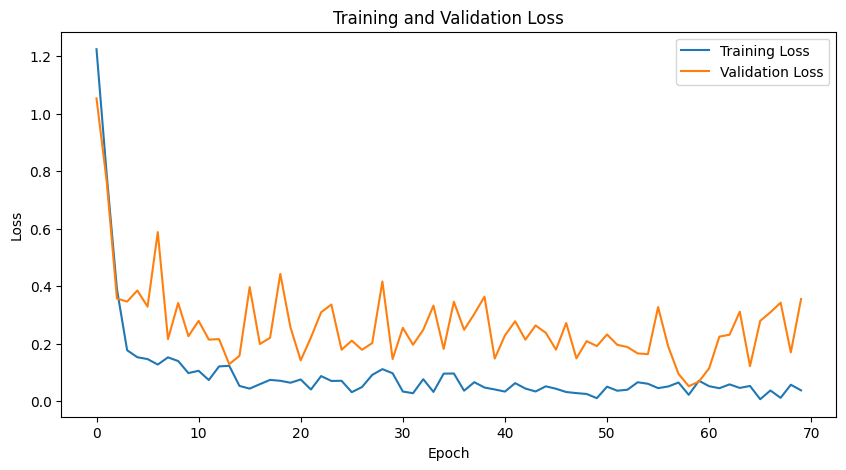

In [ ]:
# Fungsi untuk menyimpan checkpoint
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    print(f"Checkpoint saved at {filename}")

# Fungsi untuk memuat checkpoint
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    valid_losses = checkpoint['valid_losses']
    print(f"Checkpoint loaded from {filename}, starting at epoch {start_epoch}")
    return start_epoch, train_losses, valid_losses

# Optimizer dan fungsi loss
# Definisikan optimizer dengan L2 regularization (weight decay)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

# Variables to track time
total_training_time = 0
total_testing_time = 0

# Training loop with checkpoint, metrics, and timing
num_epochs = 70
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

start_epoch = 0
checkpoint_file = 'checkpoint.pth.tar'
if os.path.exists(checkpoint_file):
    start_epoch, train_losses, valid_losses = load_checkpoint(checkpoint_file)

# Start total training time
training_start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    epoch_start_time = time.time()  # Start time for each epoch

    model.train()
    train_loss = 0
    true_labels_train = []
    predicted_labels_train = []

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        if images.dim() == 3:
            images = images.unsqueeze(1)
        images = images.repeat(1, 3, 1, 1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Collect labels for metrics calculation
        predicted_labels_train.append(torch.argmax(outputs, dim=1))
        true_labels_train.append(labels)

        train_loader_tqdm.set_postfix({"Loss": loss.item()})

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Combine all predicted and true labels
    predicted_labels_train = torch.cat(predicted_labels_train)
    true_labels_train = torch.cat(true_labels_train)

    # Calculate metrics for training data
    train_accuracy = (predicted_labels_train == true_labels_train).float().mean().item()
    train_precision = precision_score(true_labels_train.cpu(), predicted_labels_train.cpu(), average='weighted', zero_division=1)
    train_recall = recall_score(true_labels_train.cpu(), predicted_labels_train.cpu(), average='weighted', zero_division=1)
    train_f1 = f1_score(true_labels_train.cpu(), predicted_labels_train.cpu(), average='weighted', zero_division=1)

    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}')

    # Validation
    valid_loss = 0
    model.eval()
    true_labels_valid = []
    predicted_labels_valid = []

    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
    with torch.no_grad():
        for images, labels in valid_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            if images.dim() == 3:
                images = images.unsqueeze(1)
            images = images.repeat(1, 3, 1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            # Collect labels for metrics calculation
            predicted_labels_valid.append(torch.argmax(outputs, dim=1))
            true_labels_valid.append(labels)

            valid_loader_tqdm.set_postfix({"Loss": loss.item()})

    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)

    # Combine all predicted and true labels
    predicted_labels_valid = torch.cat(predicted_labels_valid)
    true_labels_valid = torch.cat(true_labels_valid)

    # Calculate metrics for validation data
    valid_accuracy = (predicted_labels_valid == true_labels_valid).float().mean().item()
    valid_precision = precision_score(true_labels_valid.cpu(), predicted_labels_valid.cpu(), average='weighted', zero_division=1)
    valid_recall = recall_score(true_labels_valid.cpu(), predicted_labels_valid.cpu(), average='weighted', zero_division=1)
    valid_f1 = f1_score(true_labels_valid.cpu(), predicted_labels_valid.cpu(), average='weighted', zero_division=1)

    valid_accuracies.append(valid_accuracy)

    print(f'Validation Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.4f}, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}, F1-Score: {valid_f1:.4f}')



    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model-resnet-clahe-0,001-8-70.pth')

    # Save checkpoint every epoch
    checkpoint = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'train_losses': train_losses,
        'valid_losses': valid_losses,
    }
    save_checkpoint(checkpoint, checkpoint_file)

    # Calculate epoch time and add to total training time
    epoch_time = time.time() - epoch_start_time
    total_training_time += epoch_time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} seconds")

# End total training time
total_training_time = time.time() - training_start_time
print(f"Total training time: {total_training_time:.2f} seconds")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

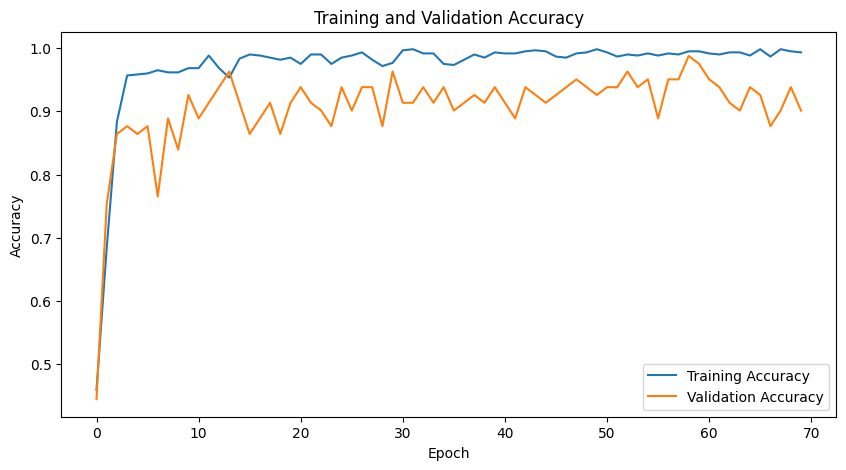

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:

# Hitung rata-rata metrik setelah semua epoch
average_train_loss = np.mean(train_losses)
average_valid_loss = np.mean(valid_losses)
average_train_accuracy = np.mean(train_accuracies)
average_valid_accuracy = np.mean(valid_accuracies)
average_train_precision = np.mean(train_precision)
average_valid_precision = np.mean(valid_precision)
average_train_recall = np.mean(train_recall)
average_valid_recall = np.mean(valid_recall)
average_train_f1 = np.mean(train_f1)
average_valid_f1 = np.mean(valid_f1)


# Display results training
print('--------------')
print(f'Training Accuracy: {average_train_accuracy * 100:.2f}%')
print(f'Training Loss: {average_train_loss:.4f}')
print(f'Training Precision: {average_train_precision:.4f}')
print(f'Training Recall: {average_train_recall:.4f}')
print(f'Training F1-Score: {average_train_f1:.4f}')


# Display results validasi
print('--------------')
print(f'Validation Accuracy: {average_valid_accuracy * 100:.2f}%')
print(f'Validation Loss: {average_valid_loss:.4f}')
print(f'Validation Precision: {average_valid_precision:.4f}')
print(f'Validation Recall: {average_valid_recall:.4f}')
print(f'Validation F1-Score: {average_valid_f1:.4f}')

--------------
Training Accuracy: 97.17%
Training Loss: 0.0966
Training Precision: 0.9934
Training Recall: 0.9933
Training F1-Score: 0.9934
--------------
Validation Accuracy: 90.69%
Validation Loss: 0.2637
Validation Precision: 0.9282
Validation Recall: 0.9012
Validation F1-Score: 0.9059


# Cell 6: Model Evaluation with Additional Metrics
"""
This cell evaluates the best model using accuracy, precision, recall, F1-score, and confusion matrix.
These metrics provide a comprehensive understanding of the model's performance on the test dataset.
"""

<ipython-input-12-611347a9e5d5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-model-resnet-clahe-0,001-8-70.pth'))
Testing: 100%|██

Total testing time: 1.25 seconds
Test Accuracy: 92.06%
Test Loss: 0.0002
Precision: 0.9301
Recall: 0.9206
F1-Score: 0.9216
Confusion Matrix:
[[110   8   0   2]
 [  0  51   0   0]
 [  0   1  53   0]
 [  8   6   0  76]]


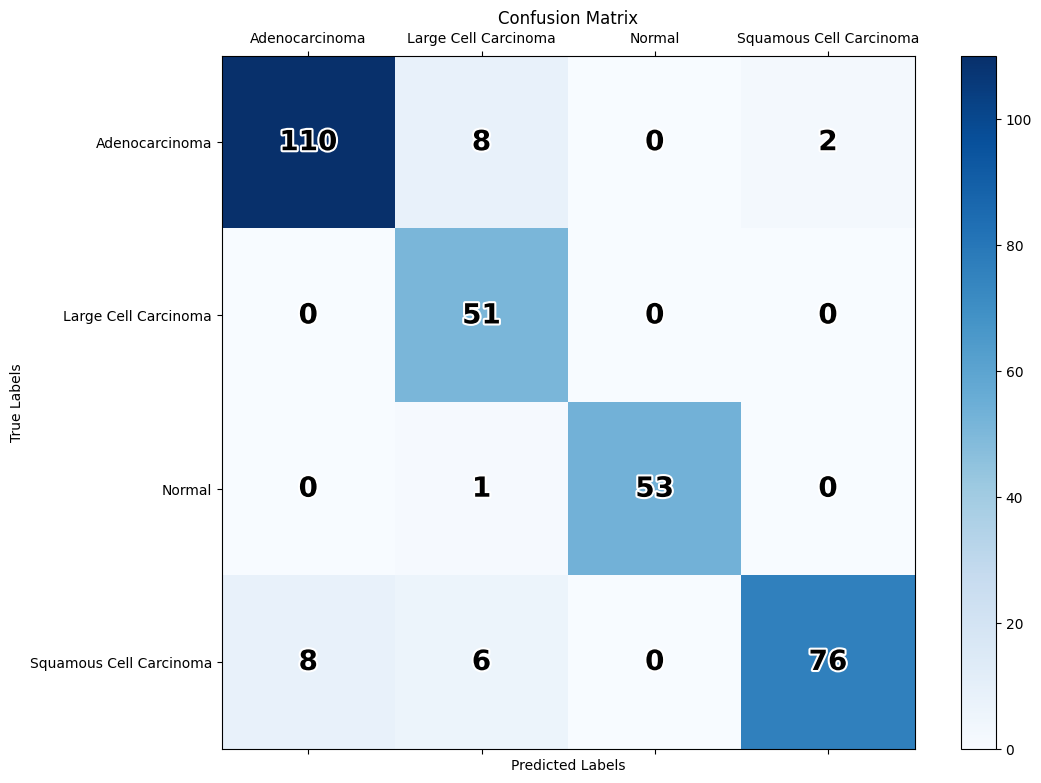

Total process time (training + testing): 605.38 seconds


In [ ]:
# Path dinamis untuk memuat model terbaik
best_model_file = '/content/drive/MyDrive/Chest-CT-Data/best-model-resnet-clahe-0,001-8-70.pth' if IN_COLAB else 'best-model.pth'
# Start testing time
testing_start_time = time.time()

# Load the best model
model.load_state_dict(torch.load('best-model-resnet-clahe-0,001-8-70.pth'))
model.eval()

# Define class labels corresponding to the numerical labels
class_labels = [
    'Adenocarcinoma',
    'Large Cell Carcinoma',
    'Normal',
    'Squamous Cell Carcinoma'
]

predicted_probabilities = []
true_labels = []

test_loader_tqdm = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for images, labels in test_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        if images.dim() == 3:
            images = images.unsqueeze(1)
        images = images.repeat(1, 3, 1, 1)
        outputs = model(images)
        probabilities = nn.functional.softmax(outputs, dim=1)
        predicted_probabilities.append(probabilities)
        true_labels.append(labels)
        test_loader_tqdm.set_postfix({"Batch Size": len(labels)})

# End testing time
total_testing_time = time.time() - testing_start_time
print(f"Total testing time: {total_testing_time:.2f} seconds")

# Calculate evaluation metrics
predicted_probabilities = torch.cat(predicted_probabilities)
true_labels = torch.cat(true_labels)
predicted_labels = torch.argmax(predicted_probabilities, dim=1)

accuracy = (predicted_labels == true_labels).float().mean().item()
precision = precision_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
recall = recall_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
f1 = f1_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
conf_matrix = confusion_matrix(true_labels.cpu(), predicted_labels.cpu())

# Display results
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test Loss: {loss:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Plot confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(12, 9))
cax = ax.matshow(conf_matrix, cmap='Blues')

# Menampilkan angka pada setiap sel dengan outline putih
for (i, j), val in np.ndenumerate(conf_matrix):
    text = ax.text(j, i, f'{val}', ha='center', va='center', color='black', fontsize=20, fontweight='bold')

    # Menambahkan outline putih di sekitar angka
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                           path_effects.Normal()])

fig.colorbar(cax)

# Set ticks dan ticklabels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Total time for the whole process
total_process_time = total_training_time + total_testing_time
print(f"Total process time (training + testing): {total_process_time:.2f} seconds")


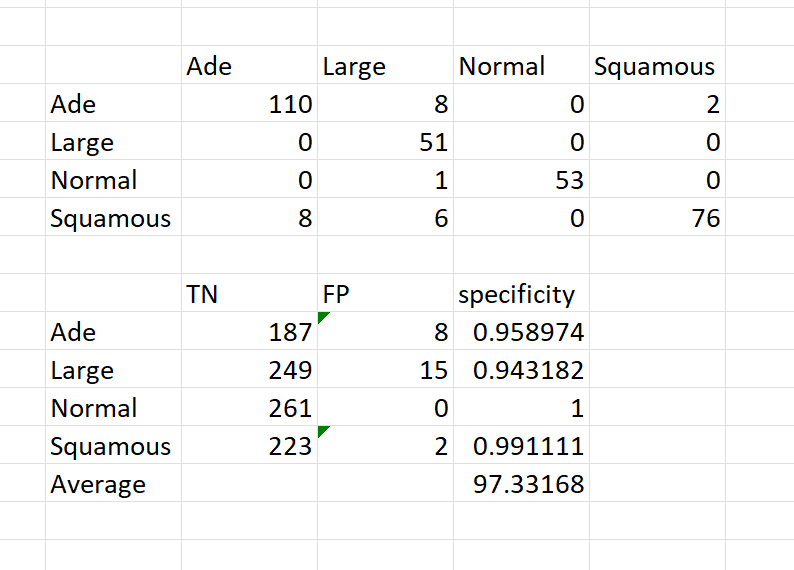